In [11]:
import numpy as np
import pandas as pd
from gen_data.gen_data import improve_resolution, add_cloud, gen_case, gen_load, gen_pv, gen_measure
from configs.config import sys_config, opt
from pypower.api import runopf
from utils.class_se import SE
from configs.config_mea_idx import define_mea_idx_noise
import matplotlib.pyplot as plt

print(opt)
print(sys_config)

{'PF_ALG': 1, 'PF_TOL': 1e-08, 'PF_MAX_IT': 10, 'PF_MAX_IT_FD': 30, 'PF_MAX_IT_GS': 1000, 'ENFORCE_Q_LIMS': False, 'PF_DC': False, 'CPF_PARAMETERIZATION': 3, 'CPF_STOP_AT': 'NOSE', 'CPF_STEP': 0.05, 'CPF_ADAPT_STEP': False, 'CPF_ERROR_TOL': 0.001, 'CPF_STEP_MIN': 0.0001, 'CPF_STEP_MAX': 0.2, 'CPF_PLOT_LEVEL': 0, 'CPF_PLOT_BUS': '', 'CPF_USER_CALLBACK': '', 'CPF_USER_CALLBACK_ARGS': '', 'OPF_ALG': 0, 'OPF_VIOLATION': 0.0005, 'OPF_FLOW_LIM': 1, 'OPF_IGNORE_ANG_LIM': False, 'OPF_ALG_DC': 0, 'VERBOSE': 0, 'OUT_ALL': 0, 'OUT_SYS_SUM': True, 'OUT_AREA_SUM': False, 'OUT_BUS': True, 'OUT_BRANCH': True, 'OUT_GEN': False, 'OUT_ALL_LIM': -1, 'OUT_V_LIM': 1, 'OUT_LINE_LIM': 1, 'OUT_PG_LIM': 1, 'OUT_QG_LIM': 1, 'RETURN_RAW_DER': 0, 'PDIPM_FEASTOL': 0, 'PDIPM_GRADTOL': 1e-06, 'PDIPM_COMPTOL': 1e-06, 'PDIPM_COSTTOL': 1e-06, 'PDIPM_MAX_IT': 150, 'SCPDIPM_RED_IT': 20}
{'case_name': 'case14', 'load_resolution': '5min', 'fpr': 0.02, 'noise_ratio_power': 0.02, 'noise_ratio_voltage': 0.001, 'pv_bus': array

In [3]:
# Load raw data
raw_load_dir = 'gen_data/raw_data/load.csv'
raw_pv_dir = 'gen_data/raw_data/pv.csv'
raw_load = pd.read_csv(raw_load_dir)
raw_pv = pd.read_csv(raw_pv_dir)
raw_load = raw_load[(raw_load['DateTime'] <= '2012-09-30 23:45:00') & (raw_load['DateTime'] >= '2012-06-00 00:00:00')]
raw_pv = raw_pv[(raw_pv['DateTime'] <= '2019-09-30 23:45:00') & (raw_pv['DateTime'] >= '2019-06-00 00:00:00')]
raw_load.reset_index(inplace=True, drop=True)
raw_pv.reset_index(inplace=True, drop = True)

In [4]:
# Improve data resolution
high_load_dir = 'gen_data/raw_data/load_high.csv'
high_pv_dir = 'gen_data/raw_data/pv_high.csv'
load_high, pv_high = improve_resolution(load_raw = raw_load, pv_raw = raw_pv, res = '5min')

# Add cloud (large deviations) to the pv dat
pv_new = add_cloud(pv_high, unchange_rate=0.5, max_reduce=0.8)

# Save
#load_high.to_csv(high_load_dir, index=False)
#pv_high.to_csv(high_pv_dir, index=False)

In [5]:
# Modify case
case = gen_case(sys_config['case_name'])
print(f'Default active load: {case["bus"][:,2]}')
print(f'Default reactive load: {case["bus"][:,3]}')
print(f'Default total active load: {case["bus"][:,2].sum()}')
print(f'Default generation limit: {case["gen"][:,8].sum()}')
# Test OPF on it
result = runopf(case, opt)
print(f'Success: {result["success"]}')
print(f'Voltage phase angle: {result["bus"][:,8]}')

Default active load: [  0.    54.25 235.5  119.5   19.    28.    75.    75.    73.75  22.5
   8.75  15.25  33.75  37.25]
Default reactive load: [ 0.  12.7 19.  -3.9  1.6  7.5  0.   0.  16.6  5.8  1.8  1.6  5.8  5. ]
Default total active load: 797.5
Default generation limit: 772.4
Success: False
Voltage phase angle: [  0.          -5.65621323 -15.70237604 -14.21631462 -11.56732536
 -15.78823337 -21.03030736 -18.45556237 -22.75527478 -22.22793426
 -19.33417167 -18.08111832 -18.71131473 -23.3454873 ]


In [6]:
# Generate load for case
high_load_dir = 'gen_data/raw_data/load_high.csv'
high_pv_dir = 'gen_data/raw_data/pv_high.csv'

load_high = pd.read_csv(high_load_dir)
pv_high = pd.read_csv(high_pv_dir)

load_active_dir = f'gen_data\{sys_config["case_name"]}\load_active.npy'
load_reactive_dir = f'gen_data\{sys_config["case_name"]}\load_reactive.npy'
load_active, load_reactive = gen_load(case = case, load_raw = load_high)
#np.save(load_active_dir, load_active, allow_pickle=True)
#np.save(load_reactive_dir, load_reactive, allow_pickle=True)

pv_active_dir = f'gen_data\{sys_config["case_name"]}\pv_active.npy'
pv_reactive_dir = f'gen_data\{sys_config["case_name"]}\pv_reactive.npy'
pv_active, pv_reactive = gen_pv(sys_config['pv_bus'], pv_high, load_active, penetration_ratio = 0.3)
#np.save(pv_active_dir, pv_active, allow_pickle=True)
#np.save(pv_reactive_dir, pv_reactive, allow_pickle=True)

Max active load: 582.6279883399718
Max pv load: 174.7883965019915
PV penetration: 0.29999999999999993
z shape: (68, 1)


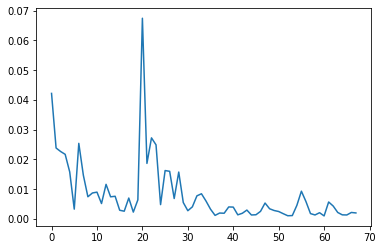

In [8]:
# Test if the maximum loads can converge in OPF
case = gen_case(sys_config['case_name'])
load_active_dir = f'gen_data/{sys_config["case_name"]}/load_active.npy'
load_reactive_dir = f'gen_data/{sys_config["case_name"]}/load_reactive.npy'

pv_active_dir = f'gen_data/{sys_config["case_name"]}/pv_active.npy'
pv_reactive_dir = f'gen_data/{sys_config["case_name"]}/pv_reactive.npy'

noise_sigma_dir = f'gen_data/{sys_config["case_name"]}/noise_sigma.npy'

load_active = np.load(load_active_dir)
load_reactive = np.load(load_reactive_dir)

pv_active = np.load(pv_active_dir)
pv_reactive = np.load(pv_reactive_dir)

# Analysis
load_max = np.max(np.sum(load_active, axis = 1))
print(f'Max active load: {load_max}')
pv_max = np.max(np.sum(pv_active, axis = 1))
print(f'Max pv load: {pv_max}')
print(f'PV penetration: {pv_max/load_max}')

# Generate noise sigma
idx, no_mea, noise_sigma = define_mea_idx_noise(case, choice = sys_config['measure_type'])
case_class = SE(case, noise_sigma, idx, fpr = sys_config['fpr'])
result = case_class.run_opf(verbose=False)
z, z_noise, vang_ref, vmag_ref = case_class.construct_mea(result)
print(f'z shape: {z_noise.shape}')
noise_sigma = np.abs(z * sys_config['noise_ratio_power']).flatten() + 1e-3
#np.save(noise_sigma_dir, noise_sigma, allow_pickle=True)
plt.plot(noise_sigma)

In [10]:
noise_sigma_dir = f'gen_data/{sys_config["case_name"]}/noise_sigma.npy'
case = gen_case(sys_config['case_name'])
idx, no_mea, noise_sigma = define_mea_idx_noise(case, choice = sys_config['measure_type'])
noise_sigma = np.load(noise_sigma_dir)
case_class = SE(case, noise_sigma, idx, fpr = sys_config['fpr'])

load_active_dir = f'gen_data/{sys_config["case_name"]}/load_active.npy'
load_reactive_dir = f'gen_data/{sys_config["case_name"]}/load_reactive.npy'
pv_active_dir = f'gen_data/{sys_config["case_name"]}/pv_active.npy'
pv_reactive_dir = f'gen_data/{sys_config["case_name"]}/pv_reactive.npy'

load_active = np.load(load_active_dir)
load_reactive = np.load(load_reactive_dir)
pv_active = np.load(pv_active_dir)
pv_reactive = np.load(pv_reactive_dir)

pv_active_ = np.zeros((load_active.shape[0], load_reactive.shape[1]))
pv_reactive_ = np.zeros((load_reactive.shape[0], load_reactive.shape[1]))
pv_active_[:,sys_config['pv_bus']] = pv_active
pv_reactive_[:,sys_config['pv_bus']] = pv_reactive

largest_load_idx = np.flip(np.argsort(np.sum(load_active - pv_active_, axis = 1)))[:10]

for i in range(10):
    result = case_class.run_opf(verbose=False, load_active = load_active[i] - pv_active_[i], load_reactive = load_reactive[i])
    print(result['success'])
    print(f'Voltage angle: {result["bus"][:,8]*np.pi/180}')
    break

"""
To make sure the largest load case can converge
"""

for i in largest_load_idx:
    result = case_class.run_opf(verbose=False, load_active = load_active[i] - pv_active_[i], load_reactive = load_reactive[i])
    print(f'total load: {np.sum(load_active[i] - pv_active_[i])}')
    print(result['success'])

True
Voltage angle: [ 0.         -0.0745777  -0.18425626 -0.15516804 -0.12961976 -0.20633625
 -0.19371142 -0.13625724 -0.22392069 -0.22510798 -0.21872675 -0.22216505
 -0.22471583 -0.24458601]
total load: 575.4147047709449
True
total load: 570.2323340055104
True
total load: 568.9799803256682
True
total load: 568.5910048448958
True
total load: 567.6804255549789
True
total load: 566.0975120449448
True
total load: 565.4247274294111
True
total load: 565.2204259385719
True
total load: 565.0539753302744
True
total load: 564.4193616259566
True
